In [1]:
%matplotlib inline

import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cpu")

In [2]:
with open('3_C_input.txt','r') as f:
    data = np.loadtxt(f)

train_data = torch.from_numpy(data[:5000])
test_data = torch.from_numpy(data[5000:])

In [3]:
#Hyperparameters
n_hidden = 10
data_dim = 3
lr = 1e-3
n_epochs = 200
batch_size = 1000

In [4]:
def rotation_tensor(theta, phi, psi):
    
    rot_x = torch.tensor([[1,0,0],[0,theta.cos(),theta.sin()],[0,-theta.sin(),theta.cos()]])
    rot_y = torch.tensor([[phi.cos(),0,-phi.sin()],[0,1,0],[phi.sin(),0,phi.cos()]])
    rot_z = torch.tensor([[phi.cos(), -phi.sin(),0],[phi.sin(),phi.cos(),0],[0,0,1]])

    return rot_x @ rot_y @ rot_z

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        #Set up priors
        self.mu1 = nn.Parameter(torch.from_numpy(3*np.random.uniform(low=-1,size=3)))
        self.mu2 = nn.Parameter(torch.from_numpy(3*np.random.uniform(low=-1,size=3)))
        self.mu3 = nn.Parameter(torch.from_numpy(3*np.random.uniform(low=-1,size=3)))
        self.mu4 = nn.Parameter(torch.from_numpy(3*np.random.uniform(low=-1,size=3)))
        self.mu5 = nn.Parameter(torch.from_numpy(3*np.random.uniform(low=-1,size=3)))
        
#         self.sig1 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3,3))))
#         self.sig2 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3,3))))
#         self.sig3 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3,3))))
#         self.sig4 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3,3))))
#         self.sig5 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3,3))))

        self.sig1 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3))))
        self.sig2 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3))))
        self.sig3 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3))))
        self.sig4 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3))))
        self.sig5 = nn.Parameter(torch.from_numpy(abs(np.random.randn(3))))
        
        self.angles1 = nn.Parameter(torch.from_numpy(2 * np.pi *np.random.uniform(size=3)))
        
        self.alpha = nn.Parameter(torch.from_numpy(abs(np.random.randn(5))))
        
        
        #Encoding
        self.fc1 = nn.Linear(3,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.fc3 = nn.Linear(n_hidden,n_hidden)
        self.fc4 = nn.Linear(n_hidden,n_hidden)
        self.fc5 = nn.Linear(n_hidden,n_hidden)
        self.fc6 = nn.Linear(n_hidden,5)
        
        
        self.dropout = nn.Dropout(p=0.5)
        self.non_lin = nn.ReLU()
        
    def encode(self,x):
        x = self.non_lin(self.fc1(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc2(x)) + x
        x = self.non_lin(self.fc3(x)) + x
        x = self.non_lin(self.fc4(x)) + x
        x = self.dropout(x)
        x = self.non_lin(self.fc5(x)) + x
        x = F.softmax(self.fc6(x))
        
        x = x**10
        
        
        return x/max(x)
        
    def forward(self,x,eps):
        
        x = self.encode(x)        
        

        a = F.softmax(self.alpha)
        y1 = self.mu1 + self.sig1 @ rotation_tensor(self.angles1[0],self.angles1[1],self.angles1[2]) @ eps[0]
        y2 = self.mu2 + self.sig2 @ eps[1]
        y3 = self.mu3 + self.sig3 @ eps[2]
        y4 = self.mu4 + self.sig4 @ eps[3]
        y5 = self.mu5 + self.sig5 @ eps[4]
        
        
        
        return y1 * x[0] * a[0] + y2 * x[1] * a[1] + y3 * x[2] * a[2] + y4 * x[3] * a[3] + y5 * x[4] * a[4]
#         return y1 * a[0] + y2 * a[1] + y3 * a[2] + y4 * a[3] + y5 * a[4]

    
    

In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch
def bce_loss_function(recon_x, x):
    BCE = F.mse_loss(recon_x, x.view(-1, 3), reduction='sum')

    return BCE #+ KLD

def kl_loss_function(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def reg_loss(model):
    alpha = F.softmax(model.alpha)
    
    loss = -F.mse_loss(model.mu1,model.mu2,reduction='sum')
    loss -= F.mse_loss(model.mu2,model.mu3,reduction='sum')
    loss -= F.mse_loss(model.mu3,model.mu4,reduction='sum')
    loss -= F.mse_loss(model.mu4,model.mu5,reduction='sum')
    loss -= F.mse_loss(model.mu1,model.mu5,reduction='sum')
    
    loss += alpha @ alpha
    
    return loss

In [7]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


def confidence_ellipse(cov, mu, ax, n_std=3.0, facecolor='none', **kwargs):
    
#     print(cov)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
#     print(pearson)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [8]:
def plot_dist(model, plot_data, dims):
    
    
    mu1 = model.mu1.detach()
    mu2 = model.mu2.detach()
    mu3 = model.mu3.detach()
    mu4 = model.mu4.detach()
    mu5 = model.mu5.detach()

    # sigma1 = model.sig1.detach()
    # sigma2 = model.sig2.detach()
    # sigma3 = model.sig3.detach()
    # sigma4 = model.sig4.detach()
    # sigma5 = model.sig5.detach()

    sigma1 = np.zeros((3,3))
    np.fill_diagonal(sigma1,model.sig1.detach())
    sigma2 = np.zeros((3,3))
    np.fill_diagonal(sigma2,model.sig2.detach())
    sigma3 = np.zeros((3,3))
    np.fill_diagonal(sigma3,model.sig3.detach())
    sigma4 = np.zeros((3,3))
    np.fill_diagonal(sigma4,model.sig4.detach())
    sigma5 = np.zeros((3,3))
    np.fill_diagonal(sigma5,model.sig5.detach())
    
    alpha = F.softmax(model.alpha).detach()

    fig, ax = plt.subplots(1,1)
#     ax.scatter(plot_data[:,dims[0]],plot_data[:,dims[1]])
    ax.hist2d(data[:,dims[0]],data[:,dims[1]],bins = 100)

#     ax.scatter(mu1[dims[0]],mu1[dims[1]],color='yellow')
#     confidence_ellipse(sigma1[dims][:,dims],mu1[dims], ax, n_std=1, edgecolor='yellow')

#     ax.scatter(mu2[dims[0]],mu2[dims[1]],color='red')
#     confidence_ellipse(sigma2[dims][:,dims],mu2[dims], ax, n_std=1, edgecolor='red')

#     ax.scatter(mu3[dims[0]],mu3[dims[1]],color='green')
#     confidence_ellipse(sigma3[dims][:,dims],mu3[dims], ax, n_std=1, edgecolor='green')

#     ax.scatter(mu4[dims[0]],mu4[dims[1]],color='purple')
#     confidence_ellipse(sigma4[dims][:,dims],mu4[dims], ax, n_std=1, edgecolor='purple')

#     ax.scatter(mu5[dims[0]],mu5[dims[1]],color='orange')
#     confidence_ellipse(sigma5[dims][:,dims],mu5[dims], ax, n_std=1, edgecolor='orange')
    
    ax.scatter(mu1[dims[0]],mu1[dims[1]],color='yellow')
    confidence_ellipse(sigma1[dims][:,dims],mu1[dims], ax, n_std=1, edgecolor='yellow')

    ax.scatter(mu2[dims[0]],mu2[dims[1]],color='red')
    confidence_ellipse(sigma2[dims][:,dims],mu2[dims], ax, n_std=1, edgecolor='red')

    ax.scatter(mu3[dims[0]],mu3[dims[1]],color='green')
    confidence_ellipse(sigma3[dims][:,dims],mu3[dims], ax, n_std=1, edgecolor='green')

    ax.scatter(mu4[dims[0]],mu4[dims[1]],color='purple')
    confidence_ellipse(sigma4[dims][:,dims],mu4[dims], ax, n_std=1, edgecolor='purple')

    ax.scatter(mu5[dims[0]],mu5[dims[1]],color='orange')
    confidence_ellipse(sigma5[dims][:,dims],mu5[dims], ax, n_std=1, edgecolor='orange')
    plt.show()
    

In [9]:
log_interval = 500
kl_coeff = 1
reg_coeff = 0.12

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_data):
        data = data.to(device)
        eps = torch.randn([5,3])
        eps.requires_grad=False
        optimizer.zero_grad()
        recon_batch = model(data.double(),eps.double())
        
        loss = bce_loss_function(recon_batch, data)
        loss += kl_coeff * kl_loss_function(model.mu1,torch.log(model.sig1))
        loss += kl_coeff * kl_loss_function(model.mu2,torch.log(model.sig2))
        loss += kl_coeff * kl_loss_function(model.mu3,torch.log(model.sig3))
        loss += kl_coeff * kl_loss_function(model.mu4,torch.log(model.sig4))
        loss += kl_coeff * kl_loss_function(model.mu5,torch.log(model.sig5))
        
        loss += reg_coeff * reg_loss(model)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data),
                100. * batch_idx / len(train_data),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_data)))
    
    print(model.angles1)
    plot_dist(model,train_data,[0,1])


In [10]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_data):
            data = data.to(device)
            eps = torch.randn([5,3])
            eps.requires_grad=False
            recon_batch = model(data, eps.double())
            test_loss += bce_loss_function(recon_batch, data).item()

    test_loss /= len(test_data)
    print('====> Test set loss: {:.4f}'.format(test_loss))


/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


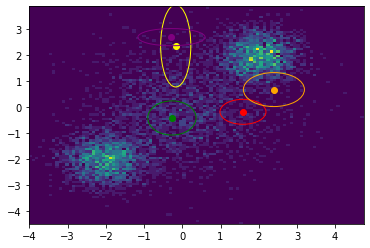

/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 1 [0/5000 (0%)]	Loss: 11.135409
Train Epoch: 1 [1500/5000 (10%)]	Loss: 9.060768
Train Epoch: 1 [3000/5000 (20%)]	Loss: 3.443594
Train Epoch: 1 [4500/5000 (30%)]	Loss: 2.076451
Train Epoch: 1 [6000/5000 (40%)]	Loss: 2.483864
Train Epoch: 1 [7500/5000 (50%)]	Loss: 8.806574
Train Epoch: 1 [9000/5000 (60%)]	Loss: 5.908943
Train Epoch: 1 [10500/5000 (70%)]	Loss: 2.474669
Train Epoch: 1 [12000/5000 (80%)]	Loss: 4.425176
Train Epoch: 1 [13500/5000 (90%)]	Loss: 1.857379
====> Epoch: 1 Average loss: 13.0152
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


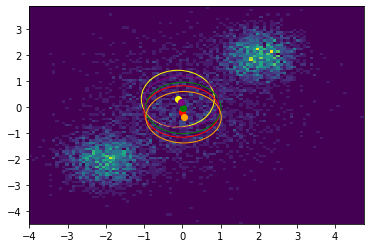

====> Test set loss: 7.2964
Train Epoch: 2 [0/5000 (0%)]	Loss: 7.802215
Train Epoch: 2 [1500/5000 (10%)]	Loss: 3.224558
Train Epoch: 2 [3000/5000 (20%)]	Loss: 3.079783
Train Epoch: 2 [4500/5000 (30%)]	Loss: 1.009669
Train Epoch: 2 [6000/5000 (40%)]	Loss: 3.011077
Train Epoch: 2 [7500/5000 (50%)]	Loss: 7.038781
Train Epoch: 2 [9000/5000 (60%)]	Loss: 5.895419
Train Epoch: 2 [10500/5000 (70%)]	Loss: 2.941258
Train Epoch: 2 [12000/5000 (80%)]	Loss: 4.120872
Train Epoch: 2 [13500/5000 (90%)]	Loss: 1.678821
====> Epoch: 2 Average loss: 10.8039
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


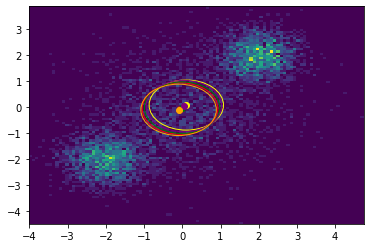

====> Test set loss: 7.2115
Train Epoch: 3 [0/5000 (0%)]	Loss: 6.890579
Train Epoch: 3 [1500/5000 (10%)]	Loss: 3.081695
Train Epoch: 3 [3000/5000 (20%)]	Loss: 4.163757
Train Epoch: 3 [4500/5000 (30%)]	Loss: 1.052715
Train Epoch: 3 [6000/5000 (40%)]	Loss: 2.565255
Train Epoch: 3 [7500/5000 (50%)]	Loss: 6.524427
Train Epoch: 3 [9000/5000 (60%)]	Loss: 6.256756
Train Epoch: 3 [10500/5000 (70%)]	Loss: 2.573152
Train Epoch: 3 [12000/5000 (80%)]	Loss: 3.734963
Train Epoch: 3 [13500/5000 (90%)]	Loss: 2.076934
====> Epoch: 3 Average loss: 10.7946
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


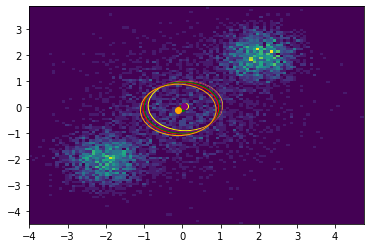

====> Test set loss: 7.1802
Train Epoch: 4 [0/5000 (0%)]	Loss: 6.813999
Train Epoch: 4 [1500/5000 (10%)]	Loss: 3.290092
Train Epoch: 4 [3000/5000 (20%)]	Loss: 4.425579
Train Epoch: 4 [4500/5000 (30%)]	Loss: 1.198107
Train Epoch: 4 [6000/5000 (40%)]	Loss: 2.896421
Train Epoch: 4 [7500/5000 (50%)]	Loss: 6.743948
Train Epoch: 4 [9000/5000 (60%)]	Loss: 5.328972
Train Epoch: 4 [10500/5000 (70%)]	Loss: 2.287126
Train Epoch: 4 [12000/5000 (80%)]	Loss: 4.264504
Train Epoch: 4 [13500/5000 (90%)]	Loss: 2.452927
====> Epoch: 4 Average loss: 10.6990
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


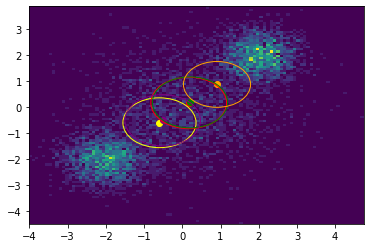

====> Test set loss: 6.9111
Train Epoch: 5 [0/5000 (0%)]	Loss: 6.995013
Train Epoch: 5 [1500/5000 (10%)]	Loss: 2.541751
Train Epoch: 5 [3000/5000 (20%)]	Loss: 4.270336
Train Epoch: 5 [4500/5000 (30%)]	Loss: 1.079602
Train Epoch: 5 [6000/5000 (40%)]	Loss: 0.655554
Train Epoch: 5 [7500/5000 (50%)]	Loss: 6.382143
Train Epoch: 5 [9000/5000 (60%)]	Loss: 4.529192
Train Epoch: 5 [10500/5000 (70%)]	Loss: 1.408175
Train Epoch: 5 [12000/5000 (80%)]	Loss: 1.826918
Train Epoch: 5 [13500/5000 (90%)]	Loss: 1.895996
====> Epoch: 5 Average loss: 9.0022
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


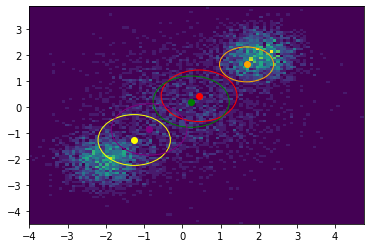

====> Test set loss: 6.5093
Train Epoch: 6 [0/5000 (0%)]	Loss: 5.076210
Train Epoch: 6 [1500/5000 (10%)]	Loss: 2.876273
Train Epoch: 6 [3000/5000 (20%)]	Loss: 3.856793
Train Epoch: 6 [4500/5000 (30%)]	Loss: 0.984595
Train Epoch: 6 [6000/5000 (40%)]	Loss: 2.368808
Train Epoch: 6 [7500/5000 (50%)]	Loss: 5.900962
Train Epoch: 6 [9000/5000 (60%)]	Loss: 5.311039
Train Epoch: 6 [10500/5000 (70%)]	Loss: 1.348493
Train Epoch: 6 [12000/5000 (80%)]	Loss: 2.530604
Train Epoch: 6 [13500/5000 (90%)]	Loss: 0.867503
====> Epoch: 6 Average loss: 7.7828
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


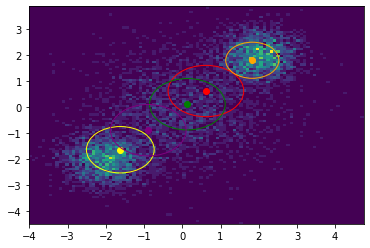

====> Test set loss: 5.4631
Train Epoch: 7 [0/5000 (0%)]	Loss: 3.754403
Train Epoch: 7 [1500/5000 (10%)]	Loss: 2.966071
Train Epoch: 7 [3000/5000 (20%)]	Loss: 2.132707
Train Epoch: 7 [4500/5000 (30%)]	Loss: 1.224304
Train Epoch: 7 [6000/5000 (40%)]	Loss: 0.573588
Train Epoch: 7 [7500/5000 (50%)]	Loss: 5.648628
Train Epoch: 7 [9000/5000 (60%)]	Loss: 6.479204
Train Epoch: 7 [10500/5000 (70%)]	Loss: 2.125998
Train Epoch: 7 [12000/5000 (80%)]	Loss: 2.870323
Train Epoch: 7 [13500/5000 (90%)]	Loss: 1.629118
====> Epoch: 7 Average loss: 7.1371
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


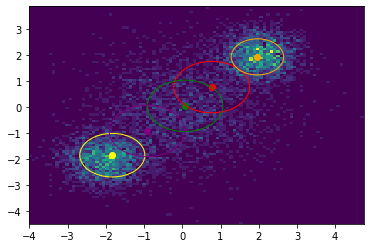

====> Test set loss: 4.7669
Train Epoch: 8 [0/5000 (0%)]	Loss: 1.323253
Train Epoch: 8 [1500/5000 (10%)]	Loss: 3.388609
Train Epoch: 8 [3000/5000 (20%)]	Loss: 4.639127
Train Epoch: 8 [4500/5000 (30%)]	Loss: 1.811207
Train Epoch: 8 [6000/5000 (40%)]	Loss: 0.732404
Train Epoch: 8 [7500/5000 (50%)]	Loss: 2.766674
Train Epoch: 8 [9000/5000 (60%)]	Loss: 1.875322
Train Epoch: 8 [10500/5000 (70%)]	Loss: 2.471559
Train Epoch: 8 [12000/5000 (80%)]	Loss: 1.161982
Train Epoch: 8 [13500/5000 (90%)]	Loss: 0.967822
====> Epoch: 8 Average loss: 7.0804
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


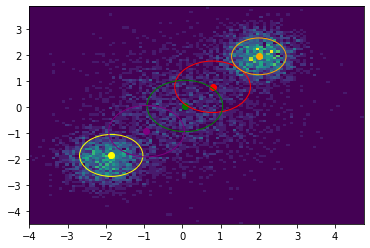

====> Test set loss: 4.8114
Train Epoch: 9 [0/5000 (0%)]	Loss: 1.711631
Train Epoch: 9 [1500/5000 (10%)]	Loss: 1.941115
Train Epoch: 9 [3000/5000 (20%)]	Loss: 1.261664
Train Epoch: 9 [4500/5000 (30%)]	Loss: 1.228480
Train Epoch: 9 [6000/5000 (40%)]	Loss: 1.504410
Train Epoch: 9 [7500/5000 (50%)]	Loss: 3.600029
Train Epoch: 9 [9000/5000 (60%)]	Loss: 4.048663
Train Epoch: 9 [10500/5000 (70%)]	Loss: 2.400899
Train Epoch: 9 [12000/5000 (80%)]	Loss: 1.153758
Train Epoch: 9 [13500/5000 (90%)]	Loss: 1.091110
====> Epoch: 9 Average loss: 7.0690
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


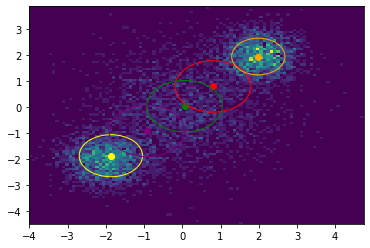

====> Test set loss: 4.8071
Train Epoch: 10 [0/5000 (0%)]	Loss: 2.618546
Train Epoch: 10 [1500/5000 (10%)]	Loss: 1.494858
Train Epoch: 10 [3000/5000 (20%)]	Loss: 2.662810
Train Epoch: 10 [4500/5000 (30%)]	Loss: 1.209963
Train Epoch: 10 [6000/5000 (40%)]	Loss: 0.824249
Train Epoch: 10 [7500/5000 (50%)]	Loss: 2.540589
Train Epoch: 10 [9000/5000 (60%)]	Loss: 6.152632
Train Epoch: 10 [10500/5000 (70%)]	Loss: 2.263284
Train Epoch: 10 [12000/5000 (80%)]	Loss: 3.340041
Train Epoch: 10 [13500/5000 (90%)]	Loss: 1.381241
====> Epoch: 10 Average loss: 7.0472
Parameter containing:
tensor([4.9593, 5.9453, 3.0468], dtype=torch.float64, requires_grad=True)


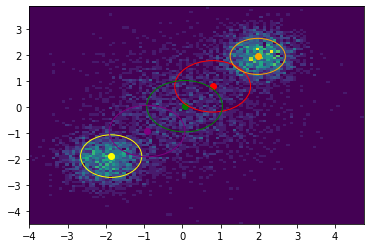

====> Test set loss: 4.8591


In [11]:
epochs = 10
model = Autoencoder().to(device).double()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 0.01)

plot_dist(model,data,[0,1])

for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)

/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


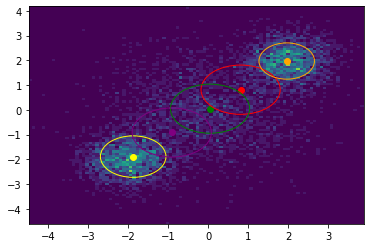

In [12]:
plot_dist(model,data,[1,2])

In [13]:
yellow = []
red = []
green = []
purple = []
orange = []

for datum in test_data:
    arg = np.argmax(model.encode(datum).detach())
    if arg == 0:
        yellow.append(datum.data.numpy())
    elif arg == 1:
        red.append(datum.data.numpy())
    elif arg == 2:
        green.append(datum.data.numpy())
    elif arg == 3:
        purple.append(datum.data.numpy())
    elif arg == 4:
        orange.append(datum.data.numpy())
        
yellow = np.asarray(yellow)
red = np.asarray(red)
green = np.asarray(green)
purple = np.asarray(purple)
orange = np.asarray(orange)

/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[0.98406929 0.         0.        ]
 [0.         0.97990552 0.        ]
 [0.         0.         0.98804774]]
tensor([0.4224, 0.0093, 0.0085, 0.0085, 0.5514], dtype=torch.float64)


/Users/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5, 1.0, 'Deep Learning Solution')

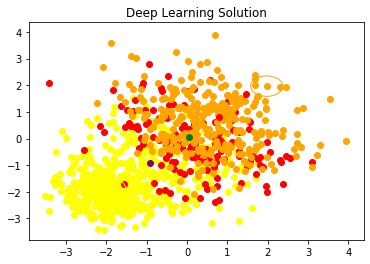

In [14]:
dims = [0,1]

mu1 = model.mu1.detach()
mu2 = model.mu2.detach()
mu3 = model.mu3.detach()
mu4 = model.mu4.detach()
mu5 = model.mu5.detach()

# sigma1 = model.sig1.detach()
# sigma2 = model.sig2.detach()
# sigma3 = model.sig3.detach()
# sigma4 = model.sig4.detach()
# sigma5 = model.sig5.detach()

sigma1 = np.zeros((3,3))
np.fill_diagonal(sigma1,model.sig1.detach())
sigma2 = np.zeros((3,3))
np.fill_diagonal(sigma2,model.sig2.detach())
sigma3 = np.zeros((3,3))
np.fill_diagonal(sigma3,model.sig3.detach())
sigma4 = np.zeros((3,3))
np.fill_diagonal(sigma4,model.sig4.detach())
sigma5 = np.zeros((3,3))
np.fill_diagonal(sigma5,model.sig5.detach())

print(sigma2)

alpha = F.softmax(model.alpha).detach()
print(alpha)

fig, ax = plt.subplots(1,1)
# ax.scatter(test_data[:,dims[0]],test_data[:,dims[1]])

if yellow.shape[0] > 1:
    ax.scatter(yellow[:,dims[0]],yellow[:,dims[1]], color='yellow')
if red.shape[0] > 1:
    ax.scatter(red[:,dims[0]],red[:,dims[1]], color='red')
if green.shape[0] > 1:
    ax.scatter(green[:,dims[0]],green[:,dims[1]], color='green')
if purple.shape[0] > 1:
    ax.scatter(purple[:,dims[0]],purple[:,dims[1]], color='purple')
if orange.shape[0] > 1:
    ax.scatter(orange[:,dims[0]],orange[:,dims[1]], color='orange')

ax.scatter(mu1[dims[0]],mu1[dims[1]],color='yellow')
confidence_ellipse(sigma1[dims][:,dims],mu1[dims], ax, n_std=alpha[0], edgecolor='yellow')

ax.scatter(mu2[dims[0]],mu2[dims[1]],color='red')
confidence_ellipse(sigma2[dims][:,dims],mu2[dims], ax, n_std=alpha[1], edgecolor='red')

ax.scatter(mu3[dims[0]],mu3[dims[1]],color='green')
confidence_ellipse(sigma3[dims][:,dims],mu3[dims], ax, n_std=alpha[2], edgecolor='green')

ax.scatter(mu4[dims[0]],mu4[dims[1]],color='purple')
confidence_ellipse(sigma4[dims][:,dims],mu4[dims], ax, n_std=alpha[3], edgecolor='purple')

ax.scatter(mu5[dims[0]],mu5[dims[1]],color='orange')
confidence_ellipse(sigma5[dims][:,dims],mu5[dims], ax, n_std=alpha[4], edgecolor='orange')

ax.set_title('Deep Learning Solution')

In [15]:
#AM_LVM Solution

mu1 = np.asarray([0.0027, -0.0448, -0.008])
sigma1 = np.asarray([[1.3419, -0.1209, -0.1155],[-0.1209, 1.3962, -0.1473],[-0.1155, -0.1473, 1.4204]])

mu2 = np.asarray([2.0149, 2.0239, 1.9948])
sigma2 = np.asarray([[0.2837, 0.0029, -0.0111],[0.0029, 0.2942, 0.0032],[-0.0111, 0.0032, 0.3232]])

mu3 = np.asarray([0.2103, 2.6066, -0.2833])
sigma3 = np.asarray([[1.0429, -0.6341, -1.1793],[-0.6341, 0.4221, 0.8273],[-1.1793, 0.8273, 1.6673]])

mu4 = np.asarray([2.7274, -0.4383, -0.8925])
sigma4 = np.asarray([[0.8289, 0.5794, 0.9571],[0.5794, 0.5967, 0.8554],[0.9571, 0.8554, 1.3019]])

mu5 = np.asarray([-1.9613, -1.9733, -1.9909])
sigma5 = np.asarray([[0.3466, 0.0034, 0.0062],[0.0034, 0.3100, -0.0017],[0.0062, -0.0017, 0.3019]])

Text(0.5, 1.0, 'AM_LVM Solution')

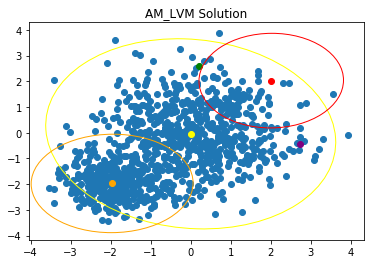

In [16]:
fig, ax = plt.subplots(1,1)
ax.scatter(test_data[:,dims[0]],test_data[:,dims[1]])

alphas = [0.3128,0.3390,0.0015,0.0030,0.3437]

ax.scatter(mu1[dims[0]],mu1[dims[1]],color='yellow')
confidence_ellipse(sigma1[dims][:,dims],mu1[dims], ax, n_std=10*alphas[0], edgecolor='yellow')

ax.scatter(mu2[dims[0]],mu2[dims[1]],color='red')
confidence_ellipse(sigma2[dims][:,dims],mu2[dims], ax, n_std=10*0.3390, edgecolor='red')

ax.scatter(mu3[dims[0]],mu3[dims[1]],color='green')
confidence_ellipse(sigma3[dims][:,dims],mu3[dims], ax, n_std=10*0.0015, edgecolor='green')

ax.scatter(mu4[dims[0]],mu4[dims[1]],color='purple')
confidence_ellipse(sigma4[dims][:,dims],mu4[dims], ax, n_std=10*0.0030, edgecolor='purple')

ax.scatter(mu5[dims[0]],mu5[dims[1]],color='orange')
confidence_ellipse(sigma5[dims][:,dims],mu5[dims], ax, n_std=10*0.3437, edgecolor='orange')

ax.set_title('AM_LVM Solution')

In [17]:
#EM Solution
mu1 = np.asarray([0.2045, -0.7439, -0.1295])
sigma1 = np.asarray([[1.4184, 0.0779, -0.1191],[0.0779, 0.8766, 0.0355],[-0.1191, 0.0355, 1.2008]])

mu2 = np.asarray([-0.5126, -0.4808, 1.3351])
sigma2 = np.asarray([[1.3553, -0.1274, -0.4330], [-0.1274, 1.5579, -0.0755], [0.4330, -0.0755, 0.9011]])

mu3 = np.asarray([2.0260, 2.0304, 2.0035])
sigma3 = np.asarray([[0.2764, 0.0009, 0.0120],[0.0009, 0.2899, 0.0046],[-0.0120, 0.0046, 0.3146]])

mu4 = np.asarray([-1.9745, -1.9859, -1.9958])
sigma4 = np.asarray([[0.3366, 0.0011, 0.0045],[0.0011, 0.3041, 0.0013],[0.0045, 0.0013, 0.2987]])

mu5 = np.asarray([-0.0074, 0.6588, -0.1699])
sigma5 = np.asarray([[1.4211, 0.0130, 0.1251],[0.0130, 1.0657, 0.1181],[0.1251, 0.1181, 1.5150]])

Text(0.5, 1.0, 'EM Solution')

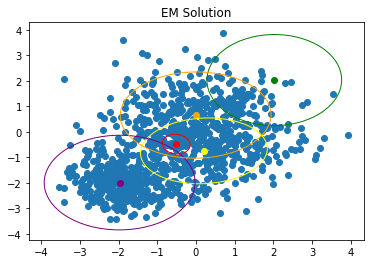

In [18]:
fig, ax = plt.subplots(1,1)
ax.scatter(test_data[:,dims[0]],test_data[:,dims[1]])

ax.scatter(mu1[dims[0]],mu1[dims[1]],color='yellow')
confidence_ellipse(sigma1[dims][:,dims],mu1[dims], ax, n_std=10*0.1377, edgecolor='yellow')

ax.scatter(mu2[dims[0]],mu2[dims[1]],color='red')
confidence_ellipse(sigma2[dims][:,dims],mu2[dims], ax, n_std=10*0.0311, edgecolor='red')

ax.scatter(mu3[dims[0]],mu3[dims[1]],color='green')
confidence_ellipse(sigma3[dims][:,dims],mu3[dims], ax, n_std=10*0.3314, edgecolor='green')

ax.scatter(mu4[dims[0]],mu4[dims[1]],color='purple')
confidence_ellipse(sigma4[dims][:,dims],mu4[dims], ax, n_std=10*0.3363, edgecolor='purple')

ax.scatter(mu5[dims[0]],mu5[dims[1]],color='orange')
confidence_ellipse(sigma5[dims][:,dims],mu5[dims], ax, n_std=10*0.1636, edgecolor='orange')

ax.set_title('EM Solution')